# <center> Aplicación en Bioestadística: Análisis de Depresión en RR.SS.
## <center>AI Saturdays Euskadi Donostia 2020

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations

In [76]:
data = pd.read_csv('../raw-data/OSF_socialmedia_data.csv')
data.head()

,Unnamed: 0,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,...,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,AutoPSMU,News,Active
0,1,115091,05/02/2017,Tuesday,10:00:06,Daily questions,1,1,1,1,...,61.0,64.0,68.0,50.0,56.0,73.0,66.0,66,39.0,38.0
1,2,115091,05/02/2017,Tuesday,12:02:48,Daily questions,2,1,1,1,...,57.0,70.0,58.0,37.0,56.0,67.0,0.0,#skipped#,27.0,23.0
2,3,115091,05/02/2017,Tuesday,14:03:02,Daily questions,3,1,1,1,...,44.0,70.0,67.0,26.0,38.0,39.0,63.0,56,34.0,36.0
3,4,115091,05/02/2017,Tuesday,16:34:28,Daily questions,4,1,1,1,...,56.0,79.0,89.0,30.0,20.0,60.0,67.0,68,29.0,23.0
4,5,115091,05/02/2017,Tuesday,18:00:00,Daily questions,5,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Análisis exploratorio de datos - EDA</h2>

In [77]:
print(f"Existen {data.shape[0]:,} filas/mediciones en el dataframe.")
print(f"Existen {data.shape[1]:,} columnas en el dataframe.")
print(f"Existen {data['Participant'].unique().size} participantes en el estudio.")

Existen 12,245 filas/mediciones en el dataframe.
Existen 26 columnas en el dataframe.
Existen 125 participantes en el estudio.


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       12245 non-null  int64  
 1   Participant                      12245 non-null  int64  
 2   Date                             12245 non-null  object 
 3   Day                              12245 non-null  object 
 4   Time                             12245 non-null  object 
 5   Session.Name                     12245 non-null  object 
 6   Notification.No                  12245 non-null  int64  
 7   LifePak.Download.No              12245 non-null  int64  
 8   Responded                        12245 non-null  int64  
 9   Completed.Session                12245 non-null  int64  
 10  Session.Instance                 8695 non-null   float64
 11  Session.Instance.Response.Lapse  8695 non-null   object 
 12  Reminders.Delivere

Seleccionamos aquellas columnas que pertenecen a los síntomas depresivos del cuestionario y observamos como se distribuyen. 

In [79]:
ESM_quest = data.iloc[:,14:-4]
ESM_quest.describe()

,Fatigue,DeprMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress
count,8653.000000,8648.000000,8646.000000,8645.000000,8646.000000,8646.000000,8650.000000,8649.000000
mean,36.990524,13.149861,11.971085,26.385772,25.501619,10.583854,12.021734,20.646896
std,29.717380,18.277533,16.962882,26.084848,26.272407,15.485521,16.732938,23.192832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,6.000000,5.000000,19.000000,18.000000,3.000000,5.000000,14.000000
75%,64.000000,20.000000,18.000000,45.000000,40.000000,17.000000,19.000000,30.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


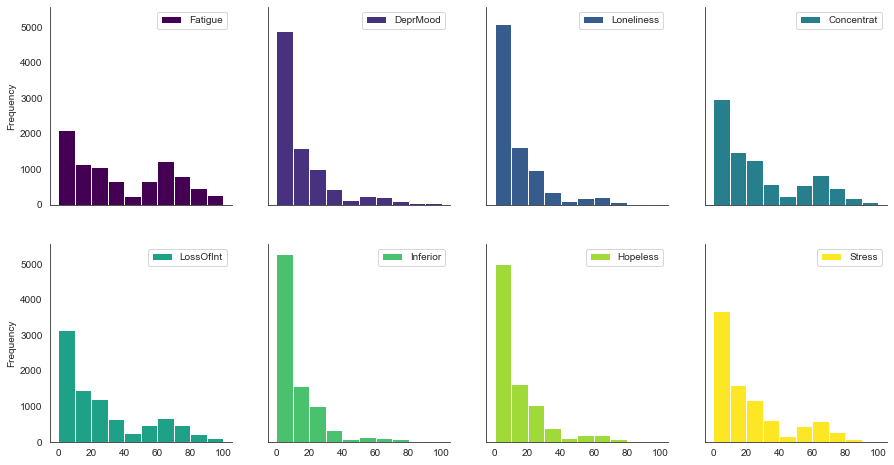

In [80]:
sns.set_style("white")
ESM_quest.plot.hist(subplots=True, layout=(2, 4), figsize=(15, 8), sharey=True,colormap='viridis')
sns.despine()

Convertimos a datetime la columna *Date*.

In [81]:
data['Date']= pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,...,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,AutoPSMU,News,Active
0,1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,...,61.0,64.0,68.0,50.0,56.0,73.0,66.0,66,39.0,38.0
1,2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,...,57.0,70.0,58.0,37.0,56.0,67.0,0.0,#skipped#,27.0,23.0
2,3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,...,44.0,70.0,67.0,26.0,38.0,39.0,63.0,56,34.0,36.0
3,4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,...,56.0,79.0,89.0,30.0,20.0,60.0,67.0,68,29.0,23.0
4,5,115091,2017-05-02,Tuesday,18:00:00,Daily questions,5,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podría ser interesante agrupar los sujetos en función de cuándo empezaron y cuándo terminaron el experimento, de tal forma que para cada grupo saber sí tendríamos series temporales *correctas*.

In [82]:
# Nuevo array con la fecha de inicio y final de cada participante

dates = pd.DataFrame([])

for participant in data.Participant.unique():
    dates = dates.append(pd.DataFrame({'start': data[data.Participant==participant].Date.min(), 'end': data[data.Participant==participant].Date.max()}, index=[0]), ignore_index=True)

dates.head()

,start,end
0,2017-05-02,2017-05-15
1,2017-05-11,2017-05-24
2,2017-04-06,2017-04-19
3,2017-04-07,2017-04-20
4,2017-04-12,2017-04-25


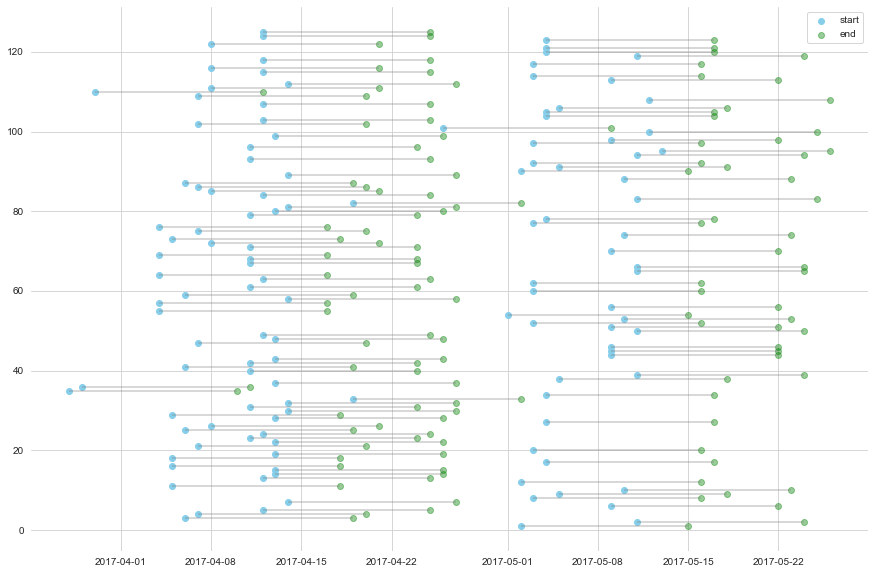

In [83]:
my_range=range(1,len(dates.index)+1)

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15, 10))

plt.hlines(y=my_range, xmin=dates.start, xmax=dates.end, color='grey', alpha=0.4)
plt.scatter(dates.start, my_range, color='skyblue', alpha=1, label='start')
plt.scatter(dates.end, my_range, color='green', alpha=0.4 , label='end')
plt.legend()
sns.despine(left=True, bottom=True, trim=True)

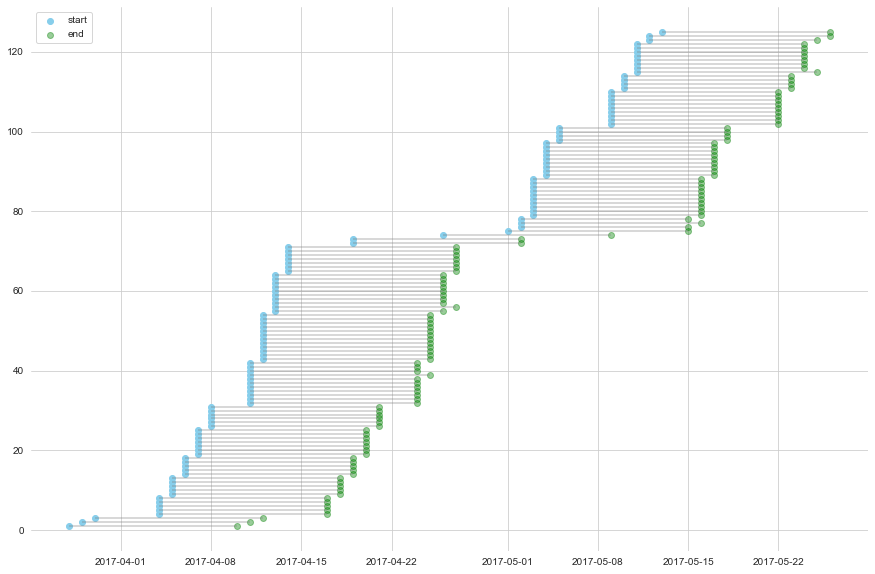

In [84]:
ordered_dates = dates.sort_values(by=['start'])

fig = plt.figure(figsize=(15, 10))

plt.hlines(y=my_range, xmin=ordered_dates.start, xmax=ordered_dates.end, color='grey', alpha=0.4)
plt.scatter(ordered_dates.start, my_range, color='skyblue', alpha=1, label='start')
plt.scatter(ordered_dates.end, my_range, color='green', alpha=0.4 , label='end')
plt.legend()
sns.despine(left=True, bottom=True, trim=True)

La publicación explica que la columna AutoPSMU hace referencia al uso automatico pasivo de las redes sociales. No obstante, muchos de los participantes debieron de "fallar" al responder a este apartado por lo que la investigación no lo tiene en cuenta. A su vez, eliminamos la columna Instr_DQs ya que unicamente cuenta con valores nulos.

In [85]:
data.drop('AutoPSMU', axis=1, inplace=True)
data.drop('Instr_DQs', axis=1, inplace=True)
data.head()

,Unnamed: 0,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,...,DeprMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,News,Active
0,1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,...,55.0,61.0,64.0,68.0,50.0,56.0,73.0,66.0,39.0,38.0
1,2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,...,59.0,57.0,70.0,58.0,37.0,56.0,67.0,0.0,27.0,23.0
2,3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,...,20.0,44.0,70.0,67.0,26.0,38.0,39.0,63.0,34.0,36.0
3,4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,...,25.0,56.0,79.0,89.0,30.0,20.0,60.0,67.0,29.0,23.0
4,5,115091,2017-05-02,Tuesday,18:00:00,Daily questions,5,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La feature *Active* se refiere a el uso activo de redes sociales, por lo que vamos a renombrarla como ASMU para que no lleve a confusiones. La feature *DeprMood* la renombramos como LowMood.

In [86]:
data.rename(columns={'Active':'ASMU'})
data.rename(columns={'DeprMood':'LowMood'})

,Unnamed: 0,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,...,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,News,Active
0,1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,...,55.0,61.0,64.0,68.0,50.0,56.0,73.0,66.0,39.0,38.0
1,2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,...,59.0,57.0,70.0,58.0,37.0,56.0,67.0,0.0,27.0,23.0
2,3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,...,20.0,44.0,70.0,67.0,26.0,38.0,39.0,63.0,34.0,36.0
3,4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,...,25.0,56.0,79.0,89.0,30.0,20.0,60.0,67.0,29.0,23.0
4,5,115091,2017-05-02,Tuesday,18:00:00,Daily questions,5,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,12241,9873359,2017-04-25,Tuesday,14:00:09,Daily questions,3,1,1,1,...,0.0,0.0,14.0,0.0,0.0,0.0,14.0,22.0,0.0,0.0
12241,12242,9873359,2017-04-25,Tuesday,16:40:58,Daily questions,4,1,1,1,...,0.0,0.0,11.0,0.0,0.0,0.0,0.0,6.0,0.0,24.0
12242,12243,9873359,2017-04-25,Tuesday,18:00:06,Daily questions,5,1,1,1,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,11.0,0.0,18.0
12243,12244,9873359,2017-04-25,Tuesday,20:05:31,Daily questions,6,1,1,1,...,0.0,8.0,22.0,8.0,0.0,0.0,15.0,10.0,0.0,0.0


Eliminamos aquellas mediciones que son consideradas como no válidas/respondidas por los autores de la publicación.

In [87]:
data = data[(data['Responded'] == 1)]
print(f"Contamos con {data.shape[0]:,} filas/mediciones en el dataframe.")

Contamos con 8,695 filas/mediciones en el dataframe.


Agregamos una nueva columna con el número de valores nulos que posee cada medición en aquellas variables de respuesta que utilizaremos posteriormente durante el modelado.

In [88]:
data['full_count'] = data.apply(lambda x: x.count()-13, axis=1)
full_count_values = data['full_count'].value_counts().sort_index()
print(full_count_values)
data.head()

0       27
1        8
2        5
3        3
4        2
5        3
6        3
7        2
8        3
9        6
10       2
11    8631
Name: full_count, dtype: int64


,Unnamed: 0,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,...,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,News,Active,full_count
0,1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,...,61.0,64.0,68.0,50.0,56.0,73.0,66.0,39.0,38.0,11
1,2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,...,57.0,70.0,58.0,37.0,56.0,67.0,0.0,27.0,23.0,11
2,3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,...,44.0,70.0,67.0,26.0,38.0,39.0,63.0,34.0,36.0,11
3,4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,...,56.0,79.0,89.0,30.0,20.0,60.0,67.0,29.0,23.0,11
5,6,115091,2017-05-02,Tuesday,20:02:12,Daily questions,6,1,1,1,...,0.0,27.0,83.0,15.0,3.0,25.0,16.0,0.0,0.0,11


Eliminamos aquellas mediciones que aún siendo consideradas mediciones válidas, poseen valores nulos en todas las variables de respuesta que utilizaremos posteriormente durante el modelado.

In [89]:
data = data.drop(data[data.full_count == 0].index)
print(f"Contamos con {data.shape[0]:,} filas/mediciones en el dataframe.")

Contamos con 8,668 filas/mediciones en el dataframe.


Ya contamos con el dataframe listo para pasar a la fase de modelado.

In [91]:
data.to_csv('../raw-data/EDA-OSF_socialmedia_data.csv')